# FloPy

### Lake Example

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

workspace = os.path.join('data')
# make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
flopy version: 3.3.1


We are creating a square model with a specified head equal to `h1` along all boundaries. The head at the cell in the center in the top layer is fixed to `h2`. First, set the name of the model and the parameters of the model: the number of layers `Nlay`, the number of rows and columns `N`, lengths of the sides of the model `L`, aquifer thickness `H`, hydraulic conductivity `k`

In [2]:
name = 'lake_example'
h1 = 100
h2 = 90
Nlay = 10 
N = 101 
L = 400.0 
H = 50.0 
k = 1.0

Create a MODFLOW model and store it (in this case in the variable `ml`, but you can call it whatever you want). The modelname will be the name given to all MODFLOW files (input and output). The exe_name should be the full path to your MODFLOW executable. The version is either 'mf2k' for MODFLOW2000 or 'mf2005'for MODFLOW2005.

In [3]:
ml = flopy.modflow.Modflow(modelname=name, exe_name='mf2005', version='mf2005', model_ws=workspace)

Define the discretization of the model. All layers are given equal thickness. The `bot` array is build from the `Hlay` values to indicate top and bottom of each layer, and `delrow` and `delcol` are computed from model size `L` and number of cells `N`. Once these are all computed, the Discretization file is built.

In [4]:
bot = np.linspace(-H/Nlay,-H,Nlay) 
delrow = delcol = L/(N-1) 
dis = flopy.modflow.ModflowDis(ml,nlay=Nlay,nrow=N,ncol=N,delr=delrow,delc=delcol,top=0.0,botm=bot,laycbd=0) 

Next we specify the boundary conditions and starting heads with the Basic package. The `ibound` array will be `1` in all cells in all layers, except for along the boundary and in the cell at the center in the top layer where it is set to `-1` to indicate fixed heads. The starting heads are used to define the heads in the fixed head cells (this is a steady simulation, so none of the other starting values matter). So we set the starting heads to `h1` everywhere, except for the head at the center of the model in the top layer.

In [5]:
Nhalf = int((N-1) / 2) 
ibound = np.ones((Nlay, N, N), dtype=np.int) 
ibound[:,0,:] = -1; ibound[:,-1,:] = -1; ibound[:,:,0] = -1; ibound[:,:,-1] = -1 
ibound[0,Nhalf,Nhalf] = -1 
start = h1 * np.ones((N,N)) 
start[Nhalf,Nhalf] = h2 
bas = flopy.modflow.ModflowBas(ml,ibound=ibound,strt=start)

The aquifer properties (really only the hydraulic conductivity) are defined with the LPF package. 

In [6]:
lpf = flopy.modflow.ModflowLpf(ml, hk=k)

Finally, we need to specify the solver we want to use (PCG with default values), and the output control (using the default values). Then we are ready to write all MODFLOW input files and run MODFLOW.

In [7]:
pcg = flopy.modflow.ModflowPcg(ml)
oc = flopy.modflow.ModflowOc(ml) 
ml.write_input()
ml.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: lake_example.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/06/26  9:36:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/06/26  9:36:05
 Elapsed run time:  0.305 Seconds

  Normal termination of simulation


(True, [])

Once the model has terminated normally, we can read the heads file. First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

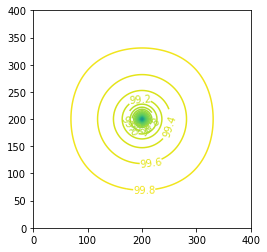

In [8]:
hds = flopy.utils.HeadFile(os.path.join(workspace, name+'.hds'))
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[0], np.arange(90,100.1,0.2))
plt.clabel(c, fmt='%2.1f')
plt.axis('scaled');

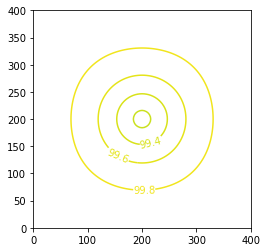

In [9]:
x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[-1], np.arange(90,100.1,0.2))
plt.clabel(c, fmt='%1.1f')
plt.axis('scaled');

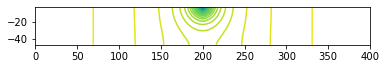

In [10]:
z = np.linspace(-H/Nlay/2, -H+H/Nlay/2, Nlay)
c = plt.contour(x, z, h[:,50,:], np.arange(90,100.1,.2))
plt.axis('scaled');